In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import csv
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, TruncatedSVD
from scipy import signal
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline

In [3]:
input_path = '../joke_recommender/data/'
df = pd.read_csv(input_path + 'joke_dataframe.csv')
df = df.drop(['Unnamed: 0', 'JokeId'], axis = 1)
df

,User1,User2,User3,User4,User5,User6,User7,User8,User9,User10,...,User73412,User73413,User73414,User73415,User73416,User73417,User73418,User73419,User73420,User73421
0,5.10,-8.79,-3.50,7.14,-8.79,9.22,-4.03,3.11,-3.64,-7.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.90,-0.87,-2.91,-3.88,-0.58,9.37,-1.55,0.92,-3.35,-5.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.75,1.99,-2.18,-3.06,-0.58,-3.93,-3.64,7.52,-6.46,-3.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-4.17,-4.61,-0.10,0.05,8.98,9.27,-6.99,0.49,-3.40,-1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.15,5.39,7.52,6.26,7.67,3.45,5.44,-0.58,1.26,4.03,...,3.64,4.32,6.99,-9.66,-8.4,-0.63,9.51,-7.67,-1.6,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6.31,-1.02,3.98,3.93,9.13,1.94,0.44,1.21,6.94,1.12,...,2.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,-4.95,-0.97,-6.46,-2.57,9.17,1.99,-0.78,5.34,5.83,0.78,...,NaN,NaN,NaN,NaN,NaN,0.78,NaN,NaN,NaN,NaN
97,-0.19,4.13,-6.89,1.07,9.17,3.45,-1.02,1.94,5.53,4.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,3.25,-1.84,-2.33,2.33,9.08,9.17,1.70,3.06,6.55,7.86,...,7.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
X = np.array(df)
scaler = MinMaxScaler(feature_range=(1,2))
scaler.fit(X)
X_transform = scaler.transform(X)
X = np.nan_to_num(X_transform)
X

array([[1.77986437, 1.06564799, 1.33225458, ..., 0.        , 0.        ,
        0.        ],
       [1.7694314 , 1.51386531, 1.36407767, ..., 0.        , 0.        ,
        0.        ],
       [1.60511215, 1.67572156, 1.403452  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.50391236, 1.79683079, 1.14940669, ..., 0.        , 0.        ,
        0.        ],
       [1.68335942, 1.45897001, 1.39536138, ..., 0.        , 0.        ,
        0.        ],
       [1.74178404, 1.73061686, 1.12297735, ..., 0.        , 0.        ,
        0.        ]])

In [6]:
X = pd.DataFrame(X)
X
#X.to_csv('scaled_df.csv')

,0,1,2,3,4,5,6,7,8,9,...,73412,73413,73414,73415,73416,73417,73418,73419,73420,73421
0,1.779864,1.065648,1.332255,1.898623,1.057602,1.992216,1.350401,1.688979,1.246819,1.114807,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,1.769431,1.513865,1.364078,1.291460,1.483653,2.000000,1.503393,1.562608,1.265267,1.250000,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,1.605112,1.675722,1.403452,1.336639,1.483653,1.309808,1.374460,1.943451,1.067430,1.351931,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,1.296296,1.302207,1.515642,1.507989,1.979761,1.994811,1.167798,1.537796,1.262087,1.437768,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,1.782473,1.868138,1.926645,1.850138,1.911780,1.692787,1.934608,1.476053,1.558524,1.742489,...,1.707087,1.765074,1.19598,1.0,1.079971,1.784543,2.0,1.142857,1.595135,1.877922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.842984,1.505376,1.735707,1.721763,1.987545,1.614427,1.626157,1.579342,1.919847,1.586373,...,1.631783,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
96,1.255608,1.508206,1.172600,1.363636,1.989621,1.617021,1.550895,1.817657,1.849237,1.568133,...,0.000000,0.000000,0.00000,0.0,0.000000,1.949649,0.0,0.000000,0.000000,0.000000
97,1.503912,1.796831,1.149407,1.564187,1.989621,1.692787,1.536089,1.621466,1.830153,1.781652,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
98,1.683359,1.458970,1.395361,1.633609,1.984951,1.989621,1.703886,1.686093,1.895038,1.947961,...,1.911406,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


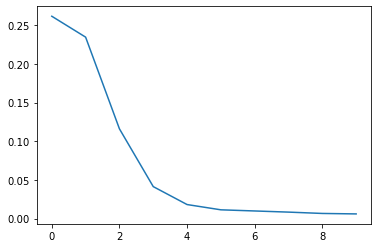

In [17]:
svd = TruncatedSVD(n_components=10)
svd.fit(X)
evr = svd.explained_variance_ratio_
sns.lineplot(x = range(0,10), y = evr)

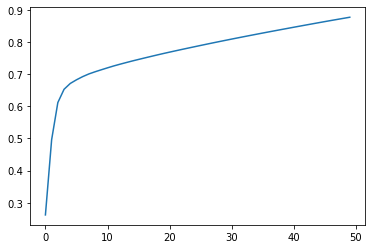

In [5]:
evr_sum = np.cumsum(evr)
sns.lineplot(x = range(0,50), y = evr_sum)

In [6]:
evr_sum

array([0.26147585, 0.49595488, 0.61198758, 0.65335751, 0.67155726,
       0.68295003, 0.69286422, 0.70129422, 0.70802735, 0.71424916,
       0.72032435, 0.72619558, 0.73155739, 0.73671434, 0.74175348,
       0.74653005, 0.75124807, 0.75589446, 0.76049875, 0.76499115,
       0.7693162 , 0.77361146, 0.77782181, 0.78197653, 0.78609289,
       0.79019614, 0.79426412, 0.79828316, 0.80223103, 0.806146  ,
       0.81004285, 0.81387492, 0.81768767, 0.8214411 , 0.82517722,
       0.82888837, 0.83256395, 0.83619921, 0.83981266, 0.84340936,
       0.84700133, 0.85055334, 0.85408849, 0.85761106, 0.8611043 ,
       0.86458936, 0.86802388, 0.87139666, 0.87475694, 0.87811418])

In [7]:
#We chose a evr_sum of 0.8
np.where(np.logical_and (evr_sum > 0.79, evr_sum < 0.81))

(array([25, 26, 27, 28, 29]),)

In [9]:
#We chose 28 principal components

In [10]:
opt_svd = TruncatedSVD(n_components=2)
opt_svd.fit(X) 

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
             random_state=None, tol=0.0)

In [ ]:
df2 = df.head(2)
corr = df2.corr()
ax = sns.heatmap(corr, vmin = 1, vmax = 2, center = 0, cmap=sns.diverging_palette(20,220,n=200), square = True);

In [33]:
model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [ ]:
def non_negative_marix_decomp(n_components, array_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, init='nndsvda', max_iter=500, random_state=0)
    W = model.fit_transform(array_data)
    
    # Normalize basis vectors to sum to 1
    Wsum = W.sum(axis=0)
    W = W/Wsum
    
    ## fix H correspondingly
    H = model.components_
    H = (H.T * Wsum).T

    nmf = (W, H)
    return(nmf)